# Assignment 10

## Assignment 10.1

In the first part of the assignment, you will implement basic text-preprocessing functions in Python. These functions do not need to scale to large text documents and will only need to handle small inputs.

### Assignment 10.1.a

Create a tokenize function that splits a sentence into words. Ensure that your tokenizer removes basic punctuation.

In [1]:
# load required libraries
import re
import numpy as np

In [2]:
def tokenize(sentence):
    tokens = []
    # tokenize the sentence
    
    # make all words lowercase
    sentence = str.lower(sentence)
    
    # remove punctuation
    sentence = re.sub(r'[^\w\s]','',sentence, re.UNICODE) 
    
    # split unpunctuated sentance and append to tokens
    for x in str.split(sentence):
        tokens.append(x)
    return tokens

### Assignment 10.1.b

Implement an `ngram` function that splits tokens into N-grams. 

In [3]:
def ngram(tokens, n):
    ngrams = []
    # Create ngrams
    
    ngram = zip(*[tokens[i:] for i in range(n)])
    
    for x in ngram:
        ngrams.append(" ".join(x))
    
    return ngrams

### Assignment 10.1.c

Implement an one_hot_encode function to create a vector from a numerical vector from a list of tokens.

In [4]:
def one_hot_encode(tokens, num_words):
    token_index = {}
    results = ''
    
    for word in tokens:
        if word not in token_index:
            token_index[word] = len(token_index) + 1
            
    results = np.zeros(shape = (len(tokens), num_words, max(token_index.values()) + 1))
    
    for i, token in enumerate(tokens):
        for j, word in list(enumerate(tokens))[:num_words]:
            index = token_index.get(word)
            results[i, j, index] = 1
    
    return results

## 10.2

Using listings 6.16, 6.17, and 6.18 in Deep Learning with Python as a guide, train a sequential model with embeddings on the IMDB data found in data/external/imdb/. Produce the model performance metrics and training and validation accuracy curves within the Jupyter notebook.

In [5]:
# load required packages
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
import matplotlib.pyplot as plt

In [6]:
imdb_dir = '/Users/bretyoung/Sites/dsc650/data/external/imdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

# read training data files and create list oof text and labels

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [7]:
# tokenize the raw data

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
print('Shape of data tensor: ', data.shape)
print('Shape of labels tensor: ', labels.shape)

# assign random order to data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Split data into training and validation sets
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

Found 88582 unique tokens
Shape of data tensor:  (25000, 100)
Shape of labels tensor:  (25000,)


In [8]:
# load GloVe word-embeddings from file

glove_dir = '/Users/bretyoung/Sites/dsc650/data/external/imdb/aclImdb'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

In [9]:
# Creating GloVe word-embedding matrix

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [10]:
# define the model

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [11]:
# load pretrained word embeddings int Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [12]:
# Complie the model

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

# Fit the model
history = model.fit(x_train,
                   y_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (x_val, y_val))

# Save the model
model.save('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 105ms/step - loss: 2.7014 - acc: 0.4800 - val_loss: 0.8071 - val_acc: 0.4971
Epoch 2/10
7/7 [==============================] - 0s 63ms/step - loss: 0.4797 - acc: 0.7550 - val_loss: 1.6090 - val_acc: 0.4940
Epoch 3/10
7/7 [==============================] - 0s 71ms/step - loss: 0.5243 - acc: 0.7600 - val_loss: 1.3201 - val_acc: 0.5060
Epoch 4/10
7/7 [==============================] - 0s 62ms/step - loss: 0.3482 - acc: 0.8250 - val_loss: 0.7523 - val_acc: 0.5313
Epoch 5/10
7/7 [==============================] - 0s 59ms/step - loss: 0.1764 - acc: 0.9850 - val_loss: 1.7046 - val_acc: 0.4946
Epoch 6/10
7/7 [==============================] - 0s 60ms/step - loss: 0.1726 - acc: 0.9600 - val_loss: 1.0000 - val_acc: 0.5058
Epoch 7/10
7/7 [==============================] - 0s 63ms/step - loss: 0.1078 - acc: 0.9800 - val_loss: 0.7980 - val_acc: 0.5568
Epoch 8/10
7/7 [==============================] - 1s 84ms/step - loss: 0.0386 - acc: 1.0000 - va

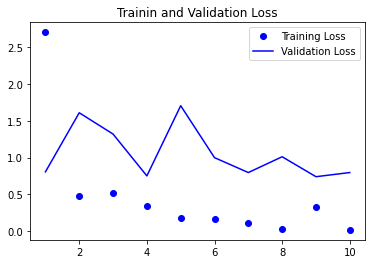

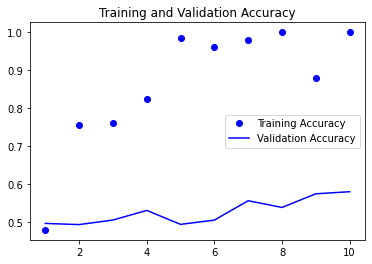

In [13]:
# Plot Validation Loss and Accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Trainin and Validation Loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [14]:
# Prepare test data

test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen = maxlen)
y_test = np.asarray(labels)

In [15]:
# evaluate the model on test data
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.8048 - acc: 0.5700


[0.8047671318054199, 0.5700399875640869]

## 10.3

Using listing 6.27 in Deep Learning with Python as a guide, fit the same data with an LSTM layer. Produce the model performance metrics and training and validation accuracy curves within the Jupyter notebook.

In [16]:
# load additional required packages

from keras.layers import LSTM
from keras.preprocessing import sequence

In [17]:
max_features = 10000
maxlen = 500
batch_size = 32

In [18]:
# Define the model

model_lstm = Sequential()
model_lstm.add(Embedding(max_features, 32))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(1, activation = 'sigmoid'))

# Compile the model
model_lstm.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])

# fit the model
history = model_lstm.fit(x_train,
              y_train,
              epochs = 10,
              batch_size = 128,
              validation_data = (x_val, y_val))

Epoch 1/10
2/2 [==============================] - 2s 807ms/step - loss: 0.6932 - acc: 0.4850 - val_loss: 0.6926 - val_acc: 0.5266
Epoch 2/10
2/2 [==============================] - 1s 534ms/step - loss: 0.6875 - acc: 0.7600 - val_loss: 0.6921 - val_acc: 0.5101
Epoch 3/10
2/2 [==============================] - 1s 644ms/step - loss: 0.6818 - acc: 0.6500 - val_loss: 0.6912 - val_acc: 0.5287
Epoch 4/10
2/2 [==============================] - 2s 805ms/step - loss: 0.6710 - acc: 0.8850 - val_loss: 0.6897 - val_acc: 0.5247
Epoch 5/10
2/2 [==============================] - 2s 808ms/step - loss: 0.6558 - acc: 0.7900 - val_loss: 0.6864 - val_acc: 0.5592
Epoch 6/10
2/2 [==============================] - 2s 907ms/step - loss: 0.6252 - acc: 0.9250 - val_loss: 0.6817 - val_acc: 0.5096
Epoch 7/10
2/2 [==============================] - 2s 830ms/step - loss: 0.5396 - acc: 0.8100 - val_loss: 0.6696 - val_acc: 0.6460
Epoch 8/10
2/2 [==============================] - 1s 706ms/step - loss: 0.5001 - acc: 0.97

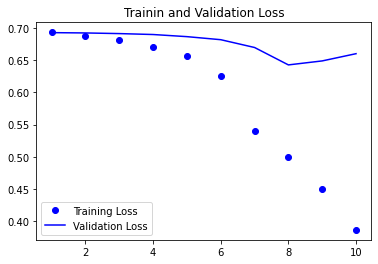

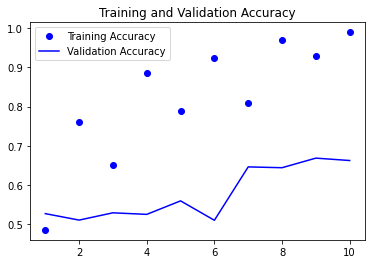

In [19]:
# Plot Validation Loss and Accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Trainin and Validation Loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [21]:
model_lstm.evaluate(x_test, y_test)

782/782 [==============================] - 7s 9ms/step - loss: 0.6679 - acc: 0.6630


[0.667850911617279, 0.6630399823188782]

## 10.4

Using listing 6.46 in Deep Learning with Python as a guide, fit the same data with a simple 1D convnet. Produce the model performance metrics and training and validation accuracy curves within the Jupyter notebook.

In [23]:
# load required packages
from keras.optimizers import RMSprop
from keras import layers

In [26]:
# Define the model

max_features = 10000
max_len = 500

model_1D = Sequential()
model_1D.add(layers.Embedding(max_features, 128, input_length = max_len))
model_1D.add(layers.Conv1D(32, 7, activation = 'relu'))
model_1D.add(layers.MaxPooling1D(5))
model_1D.add(layers.Conv1D(32, 7, activation = 'relu'))
model_1D.add(layers.GlobalMaxPooling1D())
model_1D.add(layers.Dense(1))

model_1D.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

In [29]:
# Compile the model
model_1D.compile(optimizer = RMSprop(lr = 1e-4),
                loss = 'binary_crossentropy',
                metrics = ['acc'])

# fit model
history = model.fit(x_train,
                    y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_data = (x_val, y_val))

Epoch 1/10
2/2 [==============================] - 0s 149ms/step - loss: 0.0121 - acc: 1.0000 - val_loss: 0.7867 - val_acc: 0.5787
Epoch 2/10
2/2 [==============================] - 0s 156ms/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.7880 - val_acc: 0.5873
Epoch 3/10
2/2 [==============================] - 0s 149ms/step - loss: 0.0079 - acc: 1.0000 - val_loss: 0.7985 - val_acc: 0.5837
Epoch 4/10
2/2 [==============================] - 0s 150ms/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.8048 - val_acc: 0.5879
Epoch 5/10
2/2 [==============================] - 1s 279ms/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.8191 - val_acc: 0.5817
Epoch 6/10
2/2 [==============================] - 0s 190ms/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.8242 - val_acc: 0.5814
Epoch 7/10
2/2 [==============================] - 1s 305ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.8295 - val_acc: 0.5803
Epoch 8/10
2/2 [==============================] - 0s 194ms/step - loss: 0.0041 - acc: 1.00

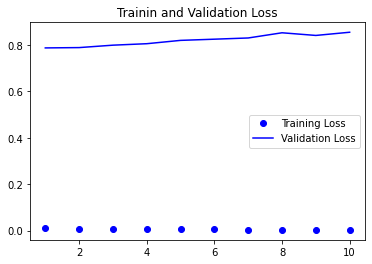

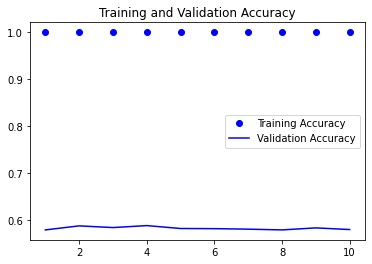

In [30]:
# Plot Validation Loss and Accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Trainin and Validation Loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [31]:
# Evaluate model
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.8685 - acc: 0.5751


[0.8684773445129395, 0.5751199722290039]